# Statistical Hypothesis Testing II

In this notebook, we will implement and apply **statistical hypothesis tests** to make inferences about risks of learning algorithms.

At the start, we will compare two learning algorithms on one domain via the paired $t$-test.

Subsequently, we will compare the two learning algorithm across multiple domains via the Wilcoxon signed-rank test.

### **Table of Contents**
1. [Paired $t$-test](#paired-t-test)
2. [Wilcoxon Signed-rank Test](#wilcoxon-signed-rank-test)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from scipy import stats

### **1. Paired $t$-test** <a class="anchor" id="paired-t-test"></a>

We implement the function [`t_test_paired`](../e2ml/evaluation/_paired_tests.py) in the [`e2ml.evaluation`](../e2ml/evaluation) subpackage. Once, the implementation has been completed, we check it for varying types of tests.

In [2]:
from e2ml.evaluation import t_test_paired
r_1 = np.round(stats.norm.rvs(loc=0.1, scale=0.03, size=40, random_state=0), 2)
r_2 = np.round(stats.norm.rvs(loc=0.12, scale=0.03, size=40, random_state=1), 2)
mu_0 = 0
t_statistic, p = t_test_paired(sample_data_1=r_1, sample_data_2=r_2, mu_0=mu_0, test_type="right-tail")
assert np.round(t_statistic, 4) == -1.4731 , 'The paired t-test statistic must be ca. -1.4731.' 
assert np.round(p, 4) == 0.9256, 'The p-value must be ca. 0.9256 for the one-sided right-tail test.' 
t_statistic, p = t_test_paired(sample_data_1=r_1, sample_data_2=r_2, mu_0=mu_0, test_type="left-tail")
assert np.round(t_statistic, 4) == -1.4731 , 'The paired t-test statistic must be ca. -1.4731.' 
assert np.round(p, 4) == 0.0744, 'The p-value must be ca. 0.0744 for the one-sided left-tail test.' 
t_statistic, p = t_test_paired(sample_data_1=r_1, sample_data_2=r_2, mu_0=mu_0, test_type="two-sided")
assert np.round(t_statistic, 4) == -1.4731 , 'The paired t-test statistic must be ca. -1.4731.' 
assert np.round(p, 4) == 0.1487, 'The p-value must be ca. 0.1487 for the two-sided test.' 

Next, we want to check whether a *support vector classifier* (SVC) significantly outperforms a *Gaussian process classifier* (GPC) on the data set breast cancer, where we use the zero-one loss as performance measure and the paired $t$-test with $\alpha=0.01$. Design and perform the corresponding evaluation study.

t-statistic: 1.2493, p-value: 0.1215, the null hypothesis is not rejected (alpha=0.01), therefore the performances are not significantly better.


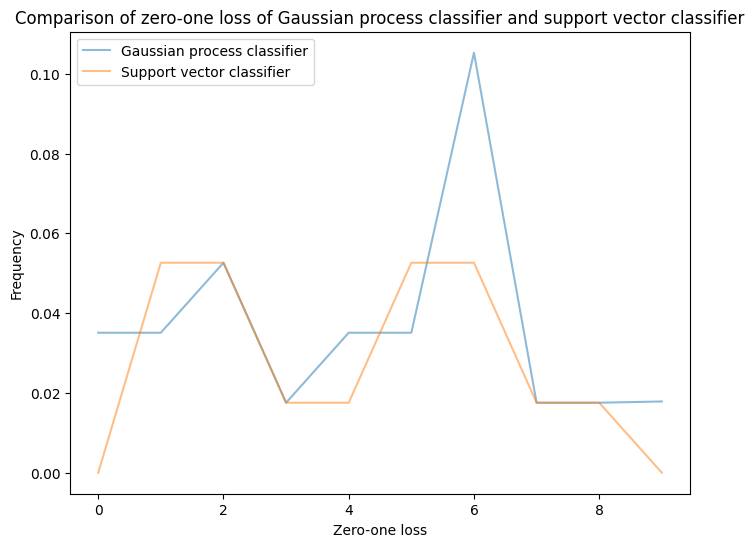

In [3]:
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.datasets import load_breast_cancer
from e2ml.evaluation import cross_validation, zero_one_loss
from e2ml.preprocessing import StandardScaler

# load data
X, y = load_breast_cancer(return_X_y=True)

# create folds
sample_indices = np.arange(len(y), dtype=np.int64)
n_folds = 10
train, test = cross_validation(sample_indices, n_folds=n_folds, y=y, random_state=42)

# prep results
risks_gpc = []
risks_svc = []

# loop through folds
for train_, test_ in zip(train, test):
    scaler = StandardScaler().fit(X[train_])
    X_train = scaler.transform(X[train_])
    X_test = scaler.transform(X[test_])
    y_train = y[train_]
    y_test = y[test_]

    # setup classifiers
    gpc = GaussianProcessClassifier(random_state=42)
    svc = SVC(random_state=42)

    # train classifier
    gpc.fit(X_train, y_train)
    svc.fit(X_train, y_train)

    # predict on test set
    y_pred_gpc = gpc.predict(X_test)
    y_pred_svc = svc.predict(X_test)

    # compute zero-one loss
    loss_gpc = zero_one_loss(y_test, y_pred_gpc)
    loss_svc = zero_one_loss(y_test, y_pred_svc)

    # save results of fold
    """
    risks_gpc.append(gpc.score(X_test, y_test))
    risks_svc.append(svc.score(X_test, y_test))
    """
    risks_gpc.append(loss_gpc)
    risks_svc.append(loss_svc)

# perform paired t-test to compare performances
alpha = 0.01
t_statistic, p = t_test_paired(sample_data_1=risks_gpc, sample_data_2=risks_svc, mu_0=0, test_type="right-tail")

print(f"t-statistic: {t_statistic:.4f}, p-value: {p:.4f}, the null hypothesis is {'' if p <= alpha else 'not '}rejected (alpha={alpha}), therefore the performances are {'' if p <= alpha else 'not '}significantly better.")

# plot results
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(risks_gpc, label="Gaussian process classifier", alpha=0.5)
ax.plot(risks_svc, label="Support vector classifier", alpha=0.5)
ax.set_xlabel("Zero-one loss")
ax.set_ylabel("Frequency")
ax.set_title("Comparison of zero-one loss of Gaussian process classifier and support vector classifier")
ax.legend()
plt.show()

#### **Questions:**
1. (a) What are possible issues of your conducted evaluation study?
     BEGIN SOLUTION

   Possible issues are:
   - We compare only the default parameter settings since we not perform a nested cross-validation.
   - The risk estimates are likely not independent since the training sets strongly overlap.
   - We likely violate the normal distribution assumptions of the paired $t$-test since the differences of zero-one loss may not be normally distributed and the number of samples is quite low.

   BEGIN SOLUTION

   bei kleinem Datensatz, sollten es nicht zu viele folds sein
   overlap training set folds -> nicht independent (test sets sind idependent)
   wenig folds -> zero/one loss normalverteilt, aber wenige Daten
   viele folds -> zero/one loss nicht normalverteilt
   default Parameter -> H_1 ist eine krasse Aussage, wenn man nur eine Parameterkombination testet

### **2. Wilcoxon Signed-rank Test** <a class="anchor" id="wilcoxon-signed-rank-test"></a>

We implement the function [`wilcoxon_signed_rank_test`](../e2ml/evaluation/_paired_tests.py) in the [`e2ml.evaluation`](../e2ml/evaluation) subpackage. Once, the implementation has been completed, we check it for varying types of tests.

In [4]:
from e2ml.evaluation import wilcoxon_signed_rank_test

# Test for exact computation.
r_1 = stats.norm.rvs(loc=0.1, scale=0.03, size=10, random_state=0)
r_2 = stats.norm.rvs(loc=0.15, scale=0.03, size=10, random_state=1)
d = r_2 - r_1
w_statistic, p = wilcoxon_signed_rank_test(sample_data_1=d, test_type="right-tail")
assert w_statistic == 47 , 'The positive rank sum statistic must be 47.'
assert np.round(p, 4) == 0.0244, 'The p-value must be ca. 0.0244 for the one-sided right-tail test.'
w_statistic, p = wilcoxon_signed_rank_test(sample_data_1=d, test_type="left-tail")
assert w_statistic == 47 , 'The positive rank sum statistic must be 47.'
assert np.round(p, 4) == 0.9814, 'The p-value must be ca. 0.9814 for the one-sided left-tail test.'
w_statistic, p = wilcoxon_signed_rank_test(sample_data_1=d, test_type="two-sided")
assert w_statistic == 47 , 'The positive rank sum statistic must be 47.'
assert np.round(p, 4) == 0.0488, 'The p-value must be ca. 0.0488 for the two-sided test.'

# Test for approximative computation.
r_1 = stats.norm.rvs(loc=2, scale=0.3, size=100, random_state=0)
r_2 = stats.norm.rvs(loc=2.1, scale=0.3, size=100, random_state=1)
d = r_2 - r_1
w_statistic, p = wilcoxon_signed_rank_test(sample_data_1=d, test_type="right-tail")
assert w_statistic == 3303 , 'The positive rank sum statistic must be 3303.' 
assert np.round(p, 4) == 0.0037, 'The p-value must be ca. 0.0037 for the one-sided right-tail test.' 
w_statistic, p = wilcoxon_signed_rank_test(sample_data_1=d, test_type="left-tail")
assert w_statistic == 3303 , 'The positive rank sum statistic must be 3303.' 
assert np.round(p, 4) == 0.9963, 'The p-value must be ca. 0.9963 for the one-sided left-tail test.' 
w_statistic, p = wilcoxon_signed_rank_test(sample_data_1=d, test_type="two-sided")
assert w_statistic == 3303 , 'The positive rank sum statistic must be 3303.' 
assert np.round(p, 4) == 0.0075, 'The p-value must be ca. 0.0075 for the two-sided test.' 

Next, we want to check whether a *support vector classifier* (SVC) significantly outperforms a *Gaussian process classifier* (GPC) on ten articially generated data sets, where we use the zero-one loss as performance measure and the paired $t$-test with $\alpha=0.01$. Design and perform the corresponding evaluation study.

In [5]:
from sklearn.datasets import make_classification

# Create 10 artificial data sets.
data_sets = []
n_classes_list = np.arange(2, 12)
for n_classes in n_classes_list:
    X, y = make_classification(
        n_samples=500, n_classes=n_classes, class_sep=2, n_informative=10, random_state=n_classes
    )
    data_sets.append((X, y))


# create folds
sample_indices = np.arange(len(y), dtype=int)
n_folds = len(data_sets) # bei kleinem Datensatz, sollten es nicht zu viele folds sein
train, test = cross_validation(sample_indices, n_folds=n_folds, y=y, random_state=0)

# set up classifiers and prepare result risk list
risk_gpc = []
risk_svc = []

# loop over folds, k-fold cross validation
for X,y in data_sets:
    risk_gpc.append([])
    risk_svc.append([])
    for train_, test_ in zip(train, test):#, data_set_ in zip(train, test, data_sets): # index list of train and test sets
        #X,y = data_set_
        scaler = StandardScaler()
        scaler.fit(X[train_])    # fit scaler on training data
        X_train = scaler.transform(X[train_])       # scale training data
        X_test = scaler.transform(X[test_])         # scale test data

        gpc = GaussianProcessClassifier(random_state=0)
        svc = SVC(random_state=0)

        # compute performance differences
        gpc.fit(X_train, y[train_])
        svc.fit(X_train, y[train_])

        # predict on test data
        y_gpc = gpc.predict(X_test)
        y_svc = svc.predict(X_test)

        # compute zero-one loss
        loss_gpc = zero_one_loss(y[test_], y_gpc)
        loss_svc = zero_one_loss(y[test_], y_svc)

        # save results of fold
        risk_gpc[-1].append(loss_gpc)
        risk_svc[-1].append(loss_svc)

risks_gpc = np.mean(risk_gpc, axis=1)
risks_svc = np.mean(risk_svc, axis=1)

# perform paired t-test to compare the performance of the classifiers
alpha = 0.01
# outperform -> losses of differences -> right tail test
w_statistic, p = wilcoxon_signed_rank_test(sample_data_1=risks_gpc, sample_data_2=risks_svc, test_type="right-tail")
if p < alpha:
    print("H_0 rejected: The SVC significantly outperforms the GPC with p-value {} (alpha={}).".format(np.round(p,4), alpha))
else:
    print("H_0 not rejected (lack of evidence): Unclear if the SVC does significantly outperform the GPC with p-value {} (alpha={}).".format(np.round(p,4), alpha))

H_0 rejected: The SVC significantly outperforms the GPC with p-value 0.001 (alpha=0.01).


#### **Questions:**
mehrere i.i.d Datensätze, mean über 10 folds per Datensatz
2. (a) What are possible issues of your conducted evaluation study?

    BEGIN SOLUTION

   Possible issues are:
   - We compare only the default parameter settings since we not perform a nested cross-validation.
   - The risk estimates are likely not independent since the artifical data sets are generated with the same method.

   BEGIN SOLUTION

   testen nur auf default parameter, keine hyperparameteroptimierung -> nicht total aussagekräftig
    Trainingsdaten überlappen -> nicht unabhängig
   Datasets müssten eigentlich gesplittet sein, eg. 5 für einen, 5 für den anderen (?)
   number of samples in test set niedrig
   belastbarer als anderes
